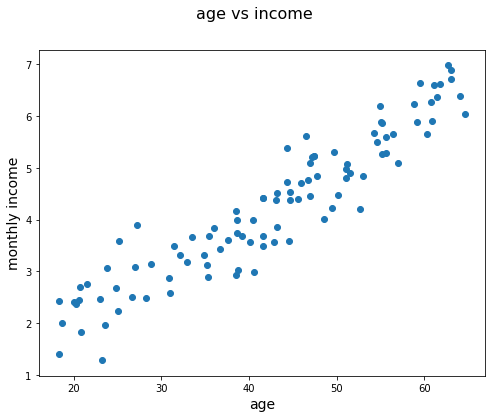

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)

age = np.random.uniform(18, 65, 100)
income = np.random.normal((age/10), 0.5)
age = age.reshape(-1,1)

fig = plt.figure(figsize=(8,6))
fig.suptitle('age vs income', fontsize=16)
plt.scatter(age, income)
plt.xlabel('age', fontsize=14)
plt.ylabel('monthly income', fontsize=14)
plt.show()

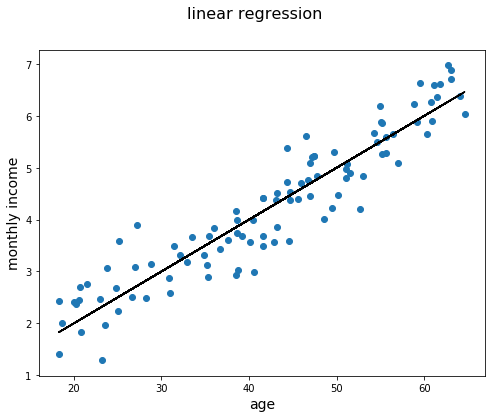

In [2]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle('linear regression', fontsize=16)
plt.scatter(age, income)
plt.plot(age, age/10, c='black')
plt.xlabel('age', fontsize=14)
plt.ylabel('monthly income', fontsize=14)
plt.show()

In [4]:
income[:5]

array([3.08382578, 5.21637114, 3.9927383 , 6.18717844, 5.50580745])

In [6]:
income_bin = income > 4
income_bin = income_bin.astype(int)
income_bin[:10]

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1])

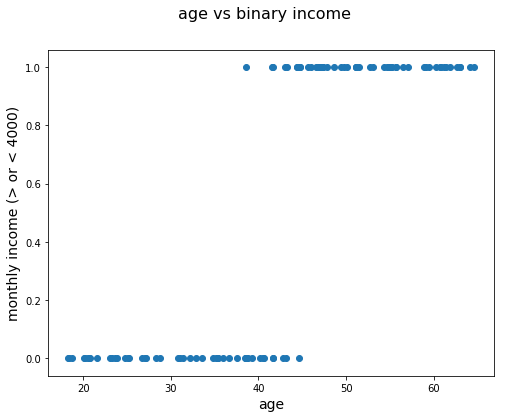

In [7]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle('age vs binary income', fontsize=16)
plt.scatter(age, income_bin)
plt.xlabel('age', fontsize=14)
plt.ylabel('monthly income (> or < 4000)', fontsize=14)
plt.show()

You can already tell that fitting a straight line will not work here. Take a look at what happens when you fit a regression line to these data.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# Create linear regression model
lin_reg = LinearRegression()
lin_reg.fit(age, income_bin)
# Store the coefficients
coef = lin_reg.coef_
interc = lin_reg.intercept_
# Create the line
lin_income = (interc + age * coef)

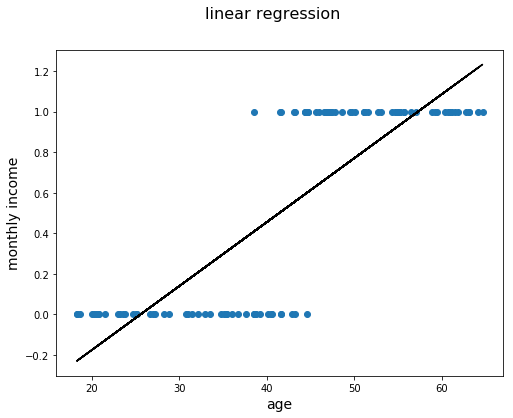

In [10]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle('linear regression', fontsize=16)
plt.scatter(age, income_bin)
plt.xlabel('age', fontsize=14)
plt.ylabel('monthly income', fontsize=14)
plt.plot(age, lin_income, c='black')
plt.show()

In [11]:
# Instantiate a Logistic regression model
# Solver must be specified to avoid warning, see documentation for more information
# liblinear is recommended for small datasets
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
regr = LogisticRegression(C=1e5, solver='liblinear')

# Fit the model to the training set
regr.fit(age, income_bin)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
# Store the coefficients
coef = regr.coef_
interc = regr.intercept_

# Create the linear predictor
lin_pred = (age * coef + interc)

# Perform the log transformation
mod_income = 1 / (1 + np.exp(-lin_pred))

# Sort the numbers to make sure plot looks right
age_ordered, mod_income_ordered = zip(*sorted(zip(age ,mod_income.ravel()),key=lambda x: x[0]))

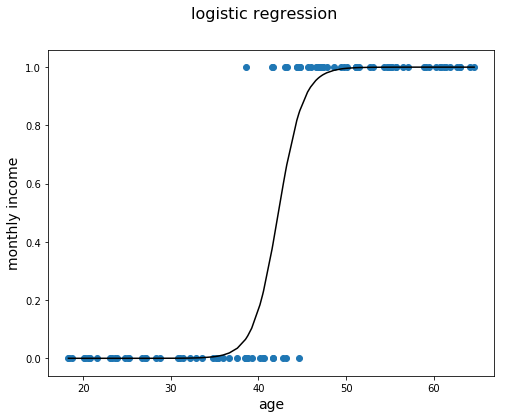

In [13]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle('logistic regression', fontsize=16)
plt.scatter(age, income_bin)
plt.xlabel('age', fontsize=14)
plt.ylabel('monthly income', fontsize=14)
plt.plot(age_ordered, mod_income_ordered, c='black')
plt.show()

The model
As you might remember from the linear regression lesson, a linear regression model can be written as:

𝑦̂ =𝛽̂ 0+𝛽̂ 1𝑥1+𝛽̂ 2𝑥2+…+𝛽𝑛𝑥𝑛
When there are 𝑛 predictors 𝑥1,…,𝑥𝑛 and 𝑛+1 parameter estimates that are estimated by the model 𝛽̂ 0,𝛽̂ 1,…,𝛽̂ 𝑛. 𝑦̂  is an estimator for the outcome variable.

Translating this model formulation to our example, this boils down to:

income=𝛽0+𝛽1age
When you want to apply this to a binary dataset, what you actually want to do is perform a classification of your data in one group versus another one. In our case, we want to classify our observations (the 100 people in our dataset) as good as possible in "earns more than 4k" and "earns less than 4k". A model will have to guess what the probability is of belonging to one group versus another. And that is exactly what logistic regression models can do!

Essentially, what happens is, the linear regression is transformed in a way that the outcome takes a value between 0 and 1. This can then be interpreted as a probability (e.g., 0.2 is a probability of 20%). Applied to our example, the expression for a logistic regression model would look like this:

𝑃(income>4000)=11+𝑒−(𝛽̂ 0+𝛽̂ 1age)
Note that the outcome is written as 𝑃(income>4000). This means that the output should be interpreted as the probability that the monthly income is over 4000 USD.

It is important to note that this is the case because the income variable was relabeled to be equal to 1 when the income is bigger than 4000, and 0 when smaller than 4000. In other words, the outcome variable should be interpreted as the probability of the class label to be equal to 1.



In [1]:
import statsmodels as sm
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy import stats

In [9]:
salaries = pd.read_csv('CSV/salaries_final.csv', index_col=0)
salaries.head()

,Age,Education,Occupation,Relationship,Race,Sex,Target
0,39,Bachelors,Adm-clerical,Not-in-family,White,Male,<=50K
1,50,Bachelors,Exec-managerial,Husband,White,Male,<=50K
2,38,HS-grad,Handlers-cleaners,Not-in-family,White,Male,<=50K
3,53,11th,Handlers-cleaners,Husband,Black,Male,<=50K
4,28,Bachelors,Prof-specialty,Wife,Black,Female,<=50K


For this example, you will fit a logistic regression model to Target using Age, Race, and Sex. Since Target, Race, and Sex are categorical, they need to be be converted to a numeric datatype first.

The get_dummies() function will only convert object and category datatypes to dummy variables so it is safe to pass Age to get_dummies(). Note that we also pass two additional arguments, drop_first=True and dtype=float. The drop_first=True argument removes the first level for each categorical variable and the dtype=float argument converts the datatype of all the dummy variables to float. The data must be float in order to obtain accurate statistical results from statsmodels.

In [10]:
# Convert race and sex using get_dummies() 
x_feats = ['Race', 'Sex', 'Age']
X = pd.get_dummies(salaries[x_feats], drop_first=True, dtype=float)

# Convert target using get_dummies
y = pd.get_dummies(salaries['Target'], drop_first=True, dtype=float)
y = y['>50K']

In [11]:
y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
32556    0.0
32557    1.0
32558    0.0
32559    0.0
32560    1.0
Name: >50K, Length: 32561, dtype: float64

In [38]:
import statsmodels.api as sm

# Create intercept term required for sm.Logit, see documentation for more information
X = sm.add_constant(X)

# Fit model
logit_model = sm.Logit(y, X)

# Get results of the fit
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.498651
         Iterations 6


In [42]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   >50K   No. Observations:                32561
Model:                          Logit   Df Residuals:                    32554
Method:                           MLE   Df Model:                            6
Date:                Tue, 02 Feb 2021   Pseudo R-squ.:                 0.09666
Time:                        21:43:18   Log-Likelihood:                -16237.
converged:                       True   LL-Null:                       -17974.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -4.4248      0.189    -23.380      0.000      -4.796      -4.054
Age                         0.0387      0.001     38.530      0.000       0.037       0.041
Race_Asian-Pac-Islander     0.9991      0.197      5.079      0.000       0.614       1.385
Race_Black                  0.1812      0.191      0.950      0.342      -0.193       0.555
Race_Other                 -0.1143      0.282     -0.406      0.685      -0.667       0.438
Race_White                  0.8742      0.183      4.782      0.000       0.516       1.232
Sex_Male                    1.2069      0.035     34.380      0.000       1.138       1.276
===========================================================================================
"""

In [43]:
np.exp(result.params)

const                      0.011977
Age                        1.039480
Race_Asian-Pac-Islander    2.715861
Race_Black                 1.198638
Race_Other                 0.891987
Race_White                 2.396965
Sex_Male                   3.343142
dtype: float64

In [44]:
logreg = LogisticRegression(fit_intercept = False, C = 1e15, solver='liblinear')
model_log = logreg.fit(X, y)
model_log

LogisticRegression(C=1000000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
model_log.coef_

array([[-4.38706342,  0.03871011,  0.96178902,  0.14397983, -0.14384057,
         0.83689457,  1.2067121 ]])

In [46]:
# Import the data
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('titanic.csv')
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [47]:
# Total number of people who survived/didn't survive
df[df.Survived == 1]['Survived'].count()
df[df.Survived == 0]['Survived'].count()

549

In [48]:
# Create dummy variables
relevant_columns = ['Pclass', 'Age', 'SibSp', 'Fare', 'Sex', 'Embarked', 'Survived']
dummy_dataframe = pd.get_dummies(df[relevant_columns], drop_first=True, dtype=float)

dummy_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Age         714 non-null    float64
 2   SibSp       891 non-null    int64  
 3   Fare        891 non-null    float64
 4   Survived    891 non-null    int64  
 5   Sex_male    891 non-null    float64
 6   Embarked_Q  891 non-null    float64
 7   Embarked_S  891 non-null    float64
dtypes: float64(5), int64(3)
memory usage: 55.8 KB


In [49]:
dummy_dataframe.head()

,Pclass,Age,SibSp,Fare,Survived,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,7.2500,0,1.0,0.0,1.0
1,1,38.0,1,71.2833,1,0.0,0.0,0.0
2,3,26.0,0,7.9250,1,0.0,0.0,1.0
3,1,35.0,1,53.1000,1,0.0,0.0,1.0
4,3,35.0,0,8.0500,0,1.0,0.0,1.0


In [50]:
# Drop missing rows
dummy_dataframe = dummy_dataframe.dropna(subset=['Age'])
dummy_dataframe

,Pclass,Age,SibSp,Fare,Survived,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,7.2500,0,1.0,0.0,1.0
1,1,38.0,1,71.2833,1,0.0,0.0,0.0
2,3,26.0,0,7.9250,1,0.0,0.0,1.0
3,1,35.0,1,53.1000,1,0.0,0.0,1.0
4,3,35.0,0,8.0500,0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...
885,3,39.0,0,29.1250,0,0.0,1.0,0.0
886,2,27.0,0,13.0000,0,1.0,0.0,1.0
887,1,19.0,0,30.0000,1,0.0,0.0,1.0
889,1,26.0,0,30.0000,1,1.0,0.0,0.0


In [51]:
# Split the data into X and y
y = dummy_dataframe.Survived
X = dummy_dataframe.drop(columns=['Survived'])

In [52]:
import statsmodels.api as sm

# Create intercept term required for sm.Logit, see documentation for more information
X = sm.add_constant(X)

# Fit model
logit_model = sm.Logit(y, X)

# Get results of the fit
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.443267
         Iterations 6


In [53]:
# Summary table
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      706
Method:                           MLE   Df Model:                            7
Date:                Wed, 03 Feb 2021   Pseudo R-squ.:                  0.3437
Time:                        08:42:50   Log-Likelihood:                -316.49
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 1.103e-67
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6503      0.633      8.921      0.000       4.409       6.892
Pclass        -1.2118      0.163     -7.433      0.000      -1.531      -0.892
Age           -0.0431      0.008     -5.250      0.000      -0.059      -0.027
SibSp         -0.3806      0.125     -3.048      0.002      -0.625      -0.136
Fare           0.0012      0.002      0.474      0.636      -0.004       0.006
Sex_male      -2.6236      0.217    -12.081      0.000      -3.049      -2.198
Embarked_Q    -0.8260      0.598     -1.381      0.167      -1.999       0.347
Embarked_S    -0.4130      0.269     -1.533      0.125      -0.941       0.115
==============================================================================
"""

## Logistic Regression in scikit-learn

In [54]:
import pandas as pd

df = pd.read_csv('titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [55]:
df = pd.get_dummies(df, drop_first=True)
print(df.columns)
df.head()

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Name_Abbott, Mr. Rossmore Edward',
       'Name_Abbott, Mrs. Stanton (Rosa Hunt)', 'Name_Abelson, Mr. Samuel',
       ...
       'Cabin_F G63', 'Cabin_F G73', 'Cabin_F2', 'Cabin_F33', 'Cabin_F38',
       'Cabin_F4', 'Cabin_G6', 'Cabin_T', 'Embarked_Q', 'Embarked_S'],
      dtype='object', length=1726)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,"Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)","Name_Abelson, Mr. Samuel",...,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0,3,35.0,0,0,8.0500,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [56]:
df = pd.read_csv('titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [57]:
x_feats = ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Cabin', 'Embarked']
X = pd.get_dummies(df[x_feats], drop_first=True)
y = df['Survived']
X.head() # Preview our data to make sure it looks reasonable

,Pclass,Age,SibSp,Fare,Sex_male,Cabin_A14,Cabin_A16,Cabin_A19,Cabin_A20,Cabin_A23,...,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_Q,Embarked_S
0,3,22.0,1,7.2500,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,38.0,1,71.2833,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,26.0,0,7.9250,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,35.0,1,53.1000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3,35.0,0,8.0500,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Normalization
Another important model tuning practice is to normalize your data. That is, if the features are on different scales, some features may impact the model more heavily then others. To level the playing field, we often normalize all features to a consistent scale of 0 to 1.

In [58]:
# Fill missing values
X = X.fillna(value=0) 
for col in X.columns:
    # Subtract the minimum and divide by the range forcing a scale of 0 to 1 for each feature
    X[col] = (X[col] - min(X[col]))/ (max(X[col]) - min(X[col])) 

X.head()

,Pclass,Age,SibSp,Fare,Sex_male,Cabin_A14,Cabin_A16,Cabin_A19,Cabin_A20,Cabin_A23,...,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_Q,Embarked_S
0,1.0,0.2750,0.125,0.014151,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.4750,0.125,0.139136,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.3250,0.000,0.015469,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.4375,0.125,0.103644,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.4375,0.000,0.015713,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Train Test Split

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Fit the model

In [60]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Predict 

In [62]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

In [63]:
import numpy as np
# We could subtract the two columns. If values or equal, difference will be zero. Then count number of zeros 
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    563
1    105
Name: Survived, dtype: int64
0    0.842814
1    0.157186
Name: Survived, dtype: float64


### Not bad; our classifier was about 85% correct on our training data!

In [67]:
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    174
1     49
Name: Survived, dtype: int64
0    0.780269
1    0.219731
Name: Survived, dtype: float64


### And still about 80% accurate on our test data!

In [68]:
from sklearn.metrics import accuracy_score

In [71]:
accuracy_score(y_test,y_hat_test)

0.7802690582959642

In [72]:
accuracy_score(y_train,y_hat_train)

0.842814371257485

In [1]:
# Import necessary functions
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
# Import data
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
# Split the data into target and predictors
y = df.target
X = df.drop(columns='target')

In [5]:
for col in X.columns:
    # Subtract the minimum and divide by the range forcing a scale of 0 to 1 for each feature
    X[col] = (X[col] - min(X[col]))/ (max(X[col]) - min(X[col])) 

X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.0,0.333333
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.0,0.666667
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.0,0.666667
3,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.0,0.129032,1.0,0.0,0.666667
4,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,1.0,0.096774,1.0,0.0,0.666667


In [6]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Instantiate the model
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
# Fit the model 
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [7]:
# Generate predictions
y_hat_train = model_log.predict(X_train)
y_hat_test = model_log.predict(X_test)

In [8]:
# Your code here
residuals = np.abs(y_train - y_hat_train)

In [9]:
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    194
1     33
Name: target, dtype: int64
0    0.854626
1    0.145374
Name: target, dtype: float64


In [10]:
# Your code here
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    62
1    14
Name: target, dtype: int64
0    0.815789
1    0.184211
Name: target, dtype: float64
